In [1]:
from timeit import default_timer as timer

import numpy as np
import matplotlib.pyplot as plt

from neuron_morphology.constants import APICAL_DENDRITE
from neuron_morphology.transforms.affine_transform import (
    rotation_from_angle, affine_from_transform_translation, AffineTransform)


# Download Apical Neuron Data

In [2]:
from lims_apical_queries import get_benchmark_apical, get_all_intact_apical, convert_coords_str
data, _ = get_benchmark_apical()

len(data)

190

In [3]:
def plot_pia_wm_soma(sdata, ax=None):
    if not ax:
        _, ax = plt.subplots()

    ax.plot(sdata['pia_coords']['x'], sdata['pia_coords']['y'])
    ax.plot(sdata['wm_coords']['x'], sdata['wm_coords']['y'])
    ax.scatter(sdata['soma_center'][0], sdata['soma_center'][1], s=10)
    ax.legend(['pia', 'wm', 'soma'])
    return ax

## Calculate True Upright Angle from Apical Dendrite

In [4]:
# Adapted from Nathan Gouwens git morph_features/morph_features/apical_projection.py
import scipy.spatial.distance as distance

def apical_trunk_line(apical_trunk):
    x = np.array([c["x"] for c in apical_trunk])
    y = np.array([c["y"] for c in apical_trunk])
    z = np.array([c["z"] for c in apical_trunk])

    data = np.vstack([x, y, z]).T
    mu = data.mean(axis=0)
    uu, dd, vv = np.linalg.svd(data - mu)
    dist = distance.euclidean(data[0, :], data[-1, :])

    linepts = vv[0] * np.mgrid[-dist/2.:dist/2.:2j][:, np.newaxis]
    linepts += mu

    return data, linepts


def identify_apical_trunk(morph, stopping_fraction=1.5):

    # find nodes along the max path until a branch where the longer path 
    # is less than stopping_fraction * the shorter path

    soma = morph.get_root()

    # max_dist[node_id] = maximum distance to leaf
    max_dist = {} 
    # path[node_id] = next_node_id where next_node_id is on the maximum path 
    # and stopping ratio hasn't been reached
    path = {}          
    to_visit = [soma]
          
    # Bottom up get max path
    while to_visit:
        node = to_visit.pop()
        children = morph.get_children(node, node_types=[APICAL_DENDRITE])
        if children:
            if all([child['id'] in max_dist for child in children]):
                if len(children) > 1:
                    shortest = (None, None)
                    longest = (None, None)
                    for child in children:
                        distance = max_dist[child['id']] + \
                            morph.get_compartment_length(morph.get_compartment_for_node(child))
                        if not shortest[0] or distance < shortest[0]:
                            shortest = (distance, child)
                        if not longest[0] or distance > longest[0]:
                            longest = (distance, child)

                    ratio = longest[0] / shortest[0]
                    max_dist[node['id']] = longest[0]
                    if ratio > stopping_fraction:
                        path[node['id']] = longest[1]['id']
                    else:
                        path[node['id']] = None
                else:
                    child = children[0]
                    max_dist[node['id']] = max_dist[child['id']] + \
                            morph.get_compartment_length(morph.get_compartment_for_node(child))
                    path[node['id']] = child['id']
            else:
                to_visit.append(node)
                for child in children:
                    if child['id'] not in max_dist:
                        to_visit.append(child) 
        else:
            path[node['id']] = None
            max_dist[node['id']] = 0

    # Traverse path, adding nodes to trunk
    child_id = path[soma['id']]          
    trunk = []
    while child_id:
        trunk.append(morph.node_by_id(child_id))
        child_id = path[child_id]
    return trunk

def signed_angle_between(v1, v2):
    return np.arctan2(v1[0] * v2[1] - v1[1] * v2[0], v1[0] * v2[0] + v1[1] * v2[1])


def get_theta_from_apical_trunk(morphology):
    apical_trunk = identify_apical_trunk(morphology)
    _, linepts = apical_trunk_line(apical_trunk)
    linepts = linepts.T

    vec = np.array([linepts[0, 1] - linepts[0, 0], linepts[1, 1] - linepts[1, 0]])
    theta = signed_angle_between(vec, [0, 1])
    return theta    

### Calculate angle for all data, removing invalid morphologies

In [5]:
from neuron_morphology.swc_io import morphology_from_swc
from neuron_morphology.validation.result import InvalidMorphology

n_data = len(data)
print(f'Estimated time to complete: {n_data / 120:.2f} mins (~0.5 seconds per neuron)')

start_time = timer()

apical_upright_results = {}
invalid_ids = []
morphologies = {}
for sid, sdata in data.items():
    try:
        morphology = morphology_from_swc(sdata['swc_file'])
        morphologies[sid] = morphology
        apical_upright_results[sid] = get_theta_from_apical_trunk(morphology)
    except InvalidMorphology as e:
        invalid_ids.append(sid)

invalid_morphologies = {sid: data.pop(sid) for sid in invalid_ids}

end_time = timer()
run_time = end_time - start_time
print(f'Elapsed time: {run_time / 60:.2f} mins ({run_time / n_data:.2f} seconds per neuron)')
print(f'{len(invalid_morphologies)} morphologies were rejected')



Estimated time to complete: 1.58 mins (~0.5 seconds per neuron)
Elapsed time: 1.42 mins (0.45 seconds per neuron)
6 morphologies were rejected


### Remove some outliers

In [6]:
outlier_ids = [323865917, 325941643, 469704261, 471758398, 479225052, 501847931, 560678143, 589128331]
try:
    outlier_apicals = {sid: data.pop(sid) for sid in outlier_ids}
    outlier_apical_upright_results = {sid: apical_upright_results.pop(sid) for sid in outlier_ids}
except KeyError as e:
    pass


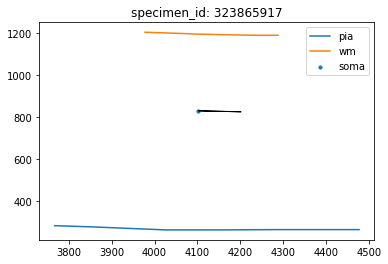

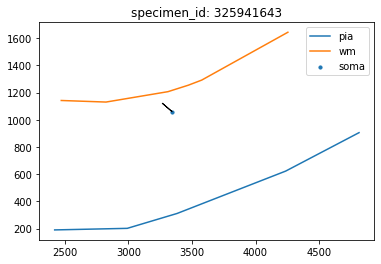

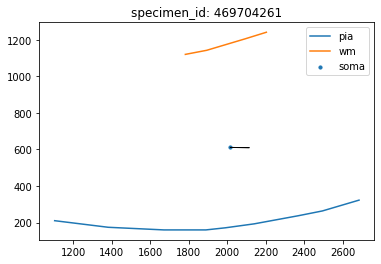

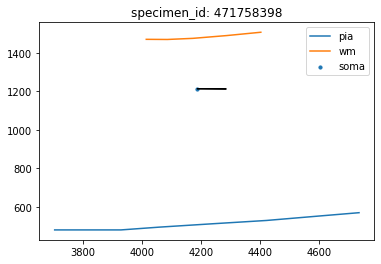

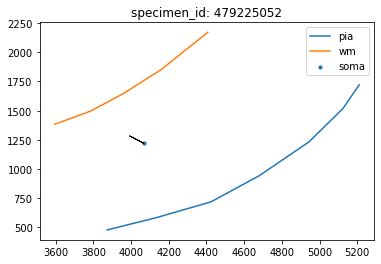

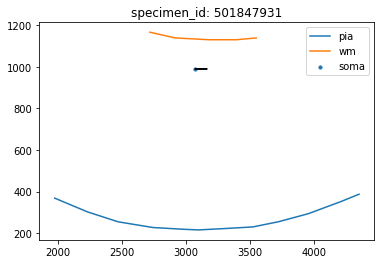

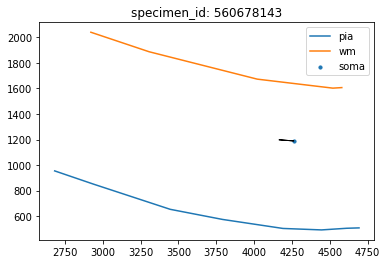

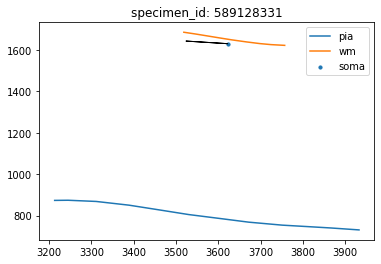

In [7]:
for sid in outlier_ids:
    sdata = outlier_apicals[sid]
    fig, ax = plt.subplots()
    plot_pia_wm_soma(sdata, ax=ax)
    
    apical_angle = outlier_apical_upright_results[sid]
    dx = 100 * np.cos(apical_angle)
    dy = 100 * np.sin(apical_angle)
    ax.arrow(sdata['soma_center'][0], sdata['soma_center'][1], dx, dy)
    ax.set_title(f'specimen_id: {sid}')
plt.show()

## Plot Apical Upright

In [8]:
def transform_coords(coords, T): 
    n_coords = coords['x'].shape[0]
    array = np.hstack((coords['x'].reshape((n_coords, 1)),
                       coords['y'].reshape((n_coords, 1)),
                       np.zeros((n_coords, 1))))
    return T.transform(array)



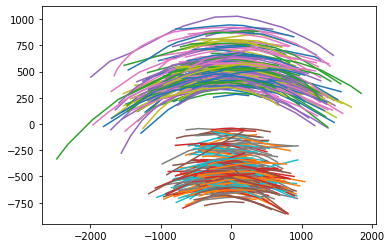

In [9]:
fig, ax = plt.subplots()

for sid, sdata in data.items():
    rot = rotation_from_angle(apical_upright_results[sid], axis=2)
    translation = np.append(-sdata['soma_center'], 0)
    affine = affine_from_transform_translation(translation=translation,
                                               transform=rot,
                                               translate_first=True)
    T = AffineTransform(affine)
    rotated_pia_coords = transform_coords(sdata['pia_coords'], T)
    rotated_wm_coords = transform_coords(sdata['wm_coords'], T)
    ax.plot(rotated_pia_coords[:, 0], rotated_pia_coords[:, 1])
    ax.plot(rotated_wm_coords[:, 0], rotated_wm_coords[:, 1])

plt.show()

In [10]:
def plot_upright_morphology(sdata, morph, up_angle, ax=None):
    if not ax:
        _, ax = plt.subplots()
    
    # Just plot the apical segments
    rot = rotation_from_angle(apical_upright_results[sid], axis=2)
    translation = np.append(-sdata['soma_center'], 0)
    affine = affine_from_transform_translation(translation=translation,
                                               transform=rot,
                                               translate_first=True)
    T = AffineTransform(affine)
    rotated_pia_coords = transform_coords(sdata['pia_coords'], T)
    rotated_wm_coords = transform_coords(sdata['wm_coords'], T)
    ax.plot(rotated_pia_coords[:, 0], rotated_pia_coords[:, 1])
    ax.plot(rotated_wm_coords[:, 0], rotated_wm_coords[:, 1])
    
    
    # resolutions are different...
    root = morph.get_root() 
    translation = -np.asarray([root['x'],root['y'],root['z']])
    affine = affine_from_transform_translation(translation=translation,
                                               transform=rot,
                                               translate_first=True)
    T = AffineTransform(affine)
    
    up_morph = T.transform_morphology(morph)
    
    segment_list = up_morph.get_segment_list(node_types=[APICAL_DENDRITE])
    for segment in segment_list:
        x = [node['x'] for node in segment]
        y = [node['y'] for node in segment]
        z = [node['z'] for node in segment]
        ax.plot(x, y)
    

    
    return ax

In [11]:
for sid, sdata in data.items():
    plot_upright_morphology(sdata, morphologies[sid], apical_upright_results[sid])
    plt.savefig(f'/home/matthew.aitken/allen_dev/sandbox/neuron_morphology_refactor/upright_figs/{sid}_apical.png')
    plt.close()

# Test Upright Methods

In [12]:
def as_deg_str(rad):
    return f'{np.degrees(rad):.2f}'

def hist_errors(method_name, method_results, apical_upright_results, outlier_threshold=15):
    errs = {sid: np.degrees(method_results[sid] - apical_upright_results[sid])
             for sid in apical_upright_results.keys()}
    errs = {sid: np.minimum(360 - err, err) for sid, err in errs.items()}
    

    fig, ax = plt.subplots()
    ax.hist(errs.values(), 50, density=True, facecolor='g', alpha=0.75)
    ax.set_xlabel('Angle Error (Deg)')
    ax.set_ylabel('Probability')
    ax.set_title(f'Histogram of {method_name} compared to Apical Upright')
    plt.show()
    
    outliers = {sid: {'Apical': as_deg_str(apical_upright_results[sid]),
                      method_name: as_deg_str(method_results[sid]),
                      'Error': err
                     }
                for sid, err in errs.items() if err > outlier_threshold}
    
    errs_arr = np.asarray(list(errs.values()))
    stats = {
    'mean_err': np.mean(errs_arr),
    'std_err': np.std(errs_arr),
    'mean_abs_err': np.mean(np.abs(errs_arr)),
    'std_abs_err': np.std(np.abs(errs_arr)),
    'rmse': np.sqrt(np.mean(errs_arr**2)),
    }
    
    return stats, outliers


## Method 1: Perpendicular to Pia

In [13]:
from scipy.spatial.distance import euclidean

def project_to_polyline(coords, target_point):
    x, y = coords["x"], coords["y"]
    points = list(map(np.array, zip(x, y)))
    dists_projs = [dist_proj_point_lineseg(target_point, q1, q2)
                   for q1, q2 in zip(points[:-1], points[1:])]
    min_idx = np.argmin(np.array([d[0] for d in dists_projs]))

    # check if the closes point is the endpoint of the whole polyline
    # - if so, extend past the edge
    if np.allclose(dists_projs[min_idx][0], points[0]) or np.allclose(dists_projs[min_idx][0], points[-1]):
        return dist_proj_point_lineseg(target_point, points[min_idx],
                                       points[min_idx + 1], clamp_to_segment=False)[1]
    else:
        return dists_projs[min_idx][1]


def dist_proj_point_lineseg(p, q1, q2, clamp_to_segment=True):
    """Find the projection of a point onto a line segment and its distance.

    based on c code from
    http://stackoverflow.com/questions/849211/shortest-distance-between-
    a-point-and-a-line-segment
    """
    l2 = euclidean(q1, q2) ** 2
    if l2 == 0:
        return euclidean(p, q1), q1  # q1 == q2 case
    if clamp_to_segment:
        t = max(0, min(1, np.dot(p - q1, q2 - q1) / l2))
    else:
        t = np.dot(p - q1, q2 - q1) / l2
    proj = q1 + t * (q2 - q1)
    return euclidean(p, proj), proj

In [14]:
perp_pia_results = {}

def perpendicular_to_pia(sdata):
    proj = project_to_polyline(sdata['pia_coords'], sdata['soma_center'])
    theta = np.arctan2((proj[1] - sdata['soma_center'][1]),
                       (proj[0] - sdata['soma_center'][0]))
    theta = np.pi /2 - theta
    return theta


for sid, sdata in data.items():
    perp_pia_results[sid] = perpendicular_to_pia(sdata)

### Errors Stats

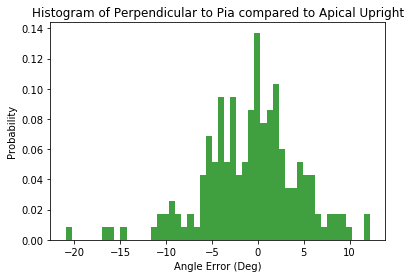

{'mean_err': -0.7877022293381437,
 'std_err': 5.216020002670487,
 'mean_abs_err': 3.9593309127825353,
 'std_abs_err': 3.4858339308474697,
 'rmse': 5.275162506535975}

In [15]:
stats, _ = hist_errors('Perpendicular to Pia', perp_pia_results, apical_upright_results)

stats

## Method 2: Ray Trace (shortest distance from wm to pia through soma)

In [16]:
from allensdk.internal.pipeline_modules.cell_types.morphology.upright_transform import calculate_shortest

n_data = len(data)
print(f'Estimated time to complete: {n_data / 2} mins (~30 seconds per neuron)')

ray_trace_results = {}

def ray_trace(sdata):
    px, py, wx, wy = calculate_shortest(sdata['soma_center_pix'][0], sdata['soma_center_pix'][1],
                                        sdata['pia_path_str'], sdata['wm_path_str'])
    
    if not px or not py or not wx or not wy:
        return float('NaN')
    
    theta = np.pi / 2 - np.arctan2((py - wy), (px - wx))
    return theta


start_time = timer()
for i, (sid, sdata) in enumerate(data.items()):
    ray_trace_results[sid] = ray_trace(sdata)
    if i % 10 == 0:
        print(f'neuron: {i} - '
              f'elapsed_time: {(timer() - start_time) / 60:.2f} mins - '
              f'{(i / n_data * 100):.2f}% complete')

end_time = timer()
run_time = end_time - start_time
print(f'Elapsed time: {run_time / 60} mins ({run_time / n_data} seconds per neuron)')

Estimated time to complete: 88.0 mins (~30 seconds per neuron)
neuron: 0 - elapsed_time: 0.14 mins - 0.00% complete
neuron: 10 - elapsed_time: 2.42 mins - 5.68% complete
neuron: 20 - elapsed_time: 5.02 mins - 11.36% complete
neuron: 30 - elapsed_time: 7.18 mins - 17.05% complete
neuron: 40 - elapsed_time: 9.52 mins - 22.73% complete
neuron: 50 - elapsed_time: 15.17 mins - 28.41% complete
neuron: 60 - elapsed_time: 19.34 mins - 34.09% complete
neuron: 70 - elapsed_time: 24.01 mins - 39.77% complete
neuron: 80 - elapsed_time: 30.33 mins - 45.45% complete
neuron: 90 - elapsed_time: 34.62 mins - 51.14% complete
neuron: 100 - elapsed_time: 40.20 mins - 56.82% complete
neuron: 110 - elapsed_time: 42.78 mins - 62.50% complete
neuron: 120 - elapsed_time: 46.32 mins - 68.18% complete
neuron: 130 - elapsed_time: 50.87 mins - 73.86% complete
neuron: 140 - elapsed_time: 54.97 mins - 79.55% complete
neuron: 150 - elapsed_time: 58.25 mins - 85.23% complete
neuron: 160 - elapsed_time: 61.70 mins - 90

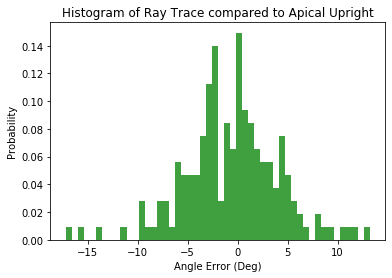

{'mean_err': -0.6081197933006827,
 'std_err': 4.762177917987283,
 'mean_abs_err': 3.624025023835247,
 'std_abs_err': 3.148744326264947,
 'rmse': 4.800848696383771}

In [17]:
stats, _ = hist_errors('Ray Trace', ray_trace_results, apical_upright_results)

stats

## Method 3: Streamline

In [18]:
from neuron_morphology.transforms.streamline import generate_laplace_field
from neuron_morphology.transforms.pia_wm_streamlines.calculate_pia_wm_streamlines import convert_path_str_to_list

def streamline(sdata):
    pia_path = convert_path_str_to_list(sdata['pia_path_str'], sdata['resolution'])
    wm_path = convert_path_str_to_list(sdata['wm_path_str'], sdata['resolution'])
    soma_center = sdata['soma_center']
    pia_path = [(x - soma_center[0], y - soma_center[1])
                for (x, y) in pia_path]
    wm_path = [(x - soma_center[0], y - soma_center[1])
               for (x, y) in wm_path]
    
    (u, grad_u, mesh, mesh_coords, mesh_values, mesh_gradients) = \
        generate_laplace_field(pia_path,
                               wm_path,
                               mesh_res=20,
                               top_value=1,
                               bottom_value=0,
                               eps_bounds=1e-8)
    soma_gradient = grad_u((0, 0))
    theta = np.pi / 2 - np.arctan2(soma_gradient[1], soma_gradient[0])
    return theta
    
    
streamline_results = {}
for i, (sid, sdata) in enumerate(data.items()):
    streamline_results[sid] = streamline(sdata)

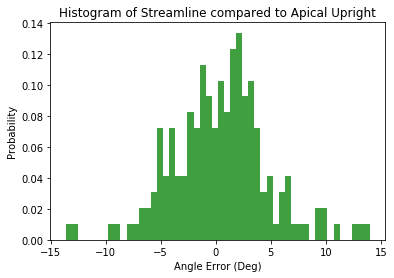

{'mean_err': 0.4216915042742703,
 'std_err': 4.407431793152348,
 'mean_abs_err': 3.3789498719270665,
 'std_abs_err': 2.8611145553911825,
 'rmse': 4.427559004244575}

In [19]:
stats, _ = hist_errors('Streamline', streamline_results, apical_upright_results)

stats